In [28]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import statsmodels.formula.api as ols

In [ ]:
# Configuration
FILE_PATH = 'Region_US48.xlsx'
START_DATE = '2019-01-01'
END_DATE = '2025-12-31'

# ==========================================
# 2. LOAD & PREP DATA
# ==========================================
print(" Loading data...")
df = pd.read_excel(FILE_PATH)
df.columns = df.columns.str.strip()

# Parse Dates
df['date_hour'] = pd.to_datetime(df['UTC time'])
df['date'] = df['date_hour'].dt.date
df['year'] = df['date_hour'].dt.year
df['month'] = df['date_hour'].dt.month
df['hour'] = df['date_hour'].dt.hour

# Filter Date Range
df = df[
    (df['date'] >= pd.to_datetime(START_DATE).date()) & 
    (df['date'] <= pd.to_datetime(END_DATE).date())
].copy()

# Create Time Trend (t=0, 1, 2...) for the interaction term
min_year = df['year'].min()
df['time_trend'] = df['year'] - min_year

# Rename Columns for easier formulas
rename_map = {
    'Demand': 'Load',
    'NG: COL': 'Gen_Coal',
    'NG: NG': 'Gen_Gas',
    'CO2 Factor: COL': 'EF_Coal', # Emission Factor (tons/MWh)
    'CO2 Factor: NG': 'EF_Gas'
}
df = df.rename(columns=rename_map)

# Clean data (remove rows where Gen_Coal or Gen_Gas is NaN)
df = df.dropna(subset=['Load', 'Gen_Coal', 'Gen_Gas'])
print(f"✅ Data loaded: {len(df)} observations")

 Loading data...
✅ Data loaded: 52608 observations


In [33]:
df

,Region,UTC time,Local date,Hour,Local time,Time zone,Demand forecast,Load,Net generation,Total interchange,...,Positive Generation,Consumed Electricity,CO2 Emissions Intensity for Generated Electricity,CO2 Emissions Intensity for Consumed Electricity,date_hour,date,year,month,hour,time_trend
30715,US48,2019-01-01 00:00:00,2018-12-31,19,2018-12-31 19:00:00,Eastern,474754,461392.0,443760.0,-1706.0,...,442532.0,447211.0,0.824117,0.825223,2019-01-01 00:00:00,2019-01-01,2019,1,0,0
30716,US48,2019-01-01 01:00:00,2018-12-31,20,2018-12-31 20:00:00,Eastern,477012,459577.0,443439.0,-2413.0,...,442212.0,448190.0,0.817595,0.817595,2019-01-01 01:00:00,2019-01-01,2019,1,1,0
30717,US48,2019-01-01 02:00:00,2018-12-31,21,2018-12-31 21:00:00,Eastern,472897,451601.0,433541.0,-2375.0,...,432479.0,439009.0,0.800748,0.800776,2019-01-01 02:00:00,2019-01-01,2019,1,2,0
30718,US48,2019-01-01 03:00:00,2018-12-31,22,2018-12-31 22:00:00,Eastern,459428,437803.0,419382.0,-816.0,...,418295.0,424292.0,0.782002,0.782005,2019-01-01 03:00:00,2019-01-01,2019,1,3,0
30719,US48,2019-01-01 04:00:00,2018-12-31,23,2018-12-31 23:00:00,Eastern,439314,422742.0,406525.0,-1224.0,...,405553.0,411308.0,0.767927,0.767927,2019-01-01 04:00:00,2019-01-01,2019,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83318,US48,2024-12-31 19:00:00,2024-12-31,14,2024-12-31 14:00:00,Eastern,441198,459552.0,457029.0,590.0,...,460822.0,461028.0,0.631405,0.632610,2024-12-31 19:00:00,2024-12-31,2024,12,19,5
83319,US48,2024-12-31 20:00:00,2024-12-31,15,2024-12-31 15:00:00,Eastern,441739,458761.0,457104.0,848.0,...,462127.0,462352.0,0.644173,0.645547,2024-12-31 20:00:00,2024-12-31,2024,12,20,5
83320,US48,2024-12-31 21:00:00,2024-12-31,16,2024-12-31 16:00:00,Eastern,445550,460248.0,458270.0,1116.0,...,465899.0,465679.0,0.654102,0.655692,2024-12-31 21:00:00,2024-12-31,2024,12,21,5
83321,US48,2024-12-31 22:00:00,2024-12-31,17,2024-12-31 17:00:00,Eastern,455162,465623.0,463020.0,815.0,...,472079.0,471948.0,0.667962,0.669954,2024-12-31 22:00:00,2024-12-31,2024,12,22,5


In [ ]:
# ==========================================
# 3. ESTIMATE PROBABILITY CHANGE (REGRESSION)
# ==========================================
# We estimate: Gen_fuel = β*Load + γ*(Load * Year) + FixedEffects
# The coefficient 'Load:time_trend' is the annual change in probability (Δp).

formula_base = " ~ Load + Load:time_trend + C(month):C(hour) + time_trend"
delta_p_results = {}

for fuel in ['Gen_Coal', 'Gen_Gas']:
    print(f"\n⏳ Running regression for {fuel} probability...")
    formula = fuel + formula_base
    
    # Fit OLS Model
    model = ols.ols(formula, data=df).fit(cov_type='HC1')
    
    # Extract the interaction coefficient
    delta_p = model.params['Load:time_trend']
    delta_p_results[fuel] = delta_p
    
    print(f" 🔹 Δp (Annual change in probability) for {fuel}: {delta_p:.5f}")
    




⏳ Running regression for Gen_Coal probability...
 🔹 Δp (Annual change in probability) for Gen_Coal: -0.01773

⏳ Running regression for Gen_Gas probability...
 🔹 Δp (Annual change in probability) for Gen_Gas: 0.00057


In [ ]:
# ==========================================
# 4. DECOMPOSITION & RESULTS
# ==========================================
# Effect = β_c * Δp_c + β_g * Δp_g

# Calculate Average Marginal Emission Factors (approximate β)
beta_c = df['EF_Coal'].mean()
beta_g = df['EF_Gas'].mean()

dp_c = delta_p_results['Gen_Coal']
dp_g = delta_p_results['Gen_Gas']

# Calculate Net Effects
effect_coal = beta_c * dp_c
effect_gas = beta_g * dp_g
total_probability_effect = effect_coal + effect_gas

# %%
# ==========================================
# 5. FINAL OUTPUT (Tabular Format)
# ==========================================

# Construct the results table
summary_data = {
    'Component': ['Coal', 'Gas', 'TOTAL NET EFFECT'],
    'Emission Intensity (β)\n[tons/MWh]': [beta_c, beta_g, np.nan],
    'Probability Shift (Δp)\n[change/year]': [dp_c, dp_g, np.nan],
    'Marginal Effect\n[tons/MWh/year]': [effect_coal, effect_gas, total_probability_effect]
}

# Create DataFrame
df_results = pd.DataFrame(summary_data)

formatted_table = df_results.style.format({
    'Emission Intensity (β)\n[tons/MWh]': "{:.3f}",
    'Probability Shift (Δp)\n[change/year]': "{:.5f}",
    'Marginal Effect\n[tons/MWh/year]': "{:+.5f}"  # Includes +/- sign
}).hide(axis='index')  # Hide the index numbers 0,1,2

# Display title
print("\n" + "="*50)
print("📊 TABLE 1: DECOMPOSITION OF MARGINAL EMISSION TRENDS")
print("="*50)

# Render the table
display(formatted_table)

# Final Conclusion Text
print("-" * 50)
if total_probability_effect > 0:
    print(f"👉 CONCLUSION: The grid is becoming DIRTIER at the margin.")
    print(f"   (Net increase of {total_probability_effect:.5f} tons CO2/MWh per year)")
else:
    print(f"👉 CONCLUSION: The grid is becoming CLEANER at the margin.")
    print(f"   (Net decrease of {abs(total_probability_effect):.5f} tons CO2/MWh per year)")


📊 TABLE 1: DECOMPOSITION OF MARGINAL EMISSION TRENDS


Component,Emission Intensity (β) [tons/MWh],Probability Shift (Δp) [change/year],Marginal Effect [tons/MWh/year]
Coal,2.245,-0.01773,-0.03980
Gas,0.905,0.00057,+0.00052
TOTAL NET EFFECT,nan,nan,-0.03928


--------------------------------------------------
👉 CONCLUSION: The grid is becoming CLEANER at the margin.
   (Net decrease of 0.03928 tons CO2/MWh per year)


In [34]:
# %%
# ==========================================
# 3. ESTIMATE DYNAMIC PROBABILITY (YEAR-BY-YEAR)
# ==========================================
# Instead of one static Δp, we calculate a unique Beta (slope) for each year.
# The "Dynamic Gamma" is the difference: Beta_2020 - Beta_2019.

years = sorted(df['year'].unique())
dynamic_results = []

print(f"📊 Running dynamic estimation for {len(years)} years...")

for year in years:
    # 1. Isolate one year of data
    df_yr = df[df['year'] == year].copy()
    
    # Store the year
    row = {'Year': year}
    
    # 2. Run Regression for Both Fuels
    # Formula: Gen = Beta * Load + Seasonality (No time trend needed within a single year)
    formula_dynamic = " ~ Load + C(month):C(hour)"
    
    for fuel in ['Gen_Coal', 'Gen_Gas']:
        # Fit OLS with Robust Errors (HC1)
        model = ols.ols(fuel + formula_dynamic, data=df_yr).fit(cov_type='HC1')
        
        # Capture the Beta (The marginal probability for this specific year)
        beta = model.params['Load']
        se = model.bse['Load']
        
        row[f'Beta_{fuel}'] = beta
        row[f'SE_{fuel}'] = se
        
    dynamic_results.append(row)

# 3. Create DataFrame & Calculate Gammas
df_dynamic = pd.DataFrame(dynamic_results)

# Gamma = The change in probability from the previous year
df_dynamic['Gamma_Coal'] = df_dynamic['Beta_Gen_Coal'].diff()
df_dynamic['Gamma_Gas']  = df_dynamic['Beta_Gen_Gas'].diff()

# 4. Display Results
print("\n" + "="*60)
print("DYNAMIC PROBABILITY RESULTS (Year-by-Year)")
print("="*60)

# Create a nice format for display
display_cols = ['Year', 'Beta_Gen_Coal', 'Gamma_Coal', 'Beta_Gen_Gas', 'Gamma_Gas']

# Apply formatting (Beta is the slope, Gamma is the change in slope)
formatted_df = df_dynamic[display_cols].style.format({
    'Beta_Gen_Coal': "{:.4f}",
    'Gamma_Coal':    "{:+.4f}",  # Shows + or - sign
    'Beta_Gen_Gas':  "{:.4f}",
    'Gamma_Gas':     "{:+.4f}"
}).hide(axis='index')

display(formatted_df)

# Interpretation Hint
print("\nINTERPRETATION:")
print("- Beta (β): The probability that this fuel is marginal in that specific year.")
print("- Gamma (γ): The CHANGE in probability compared to the previous year.")
print("  (e.g., if Gamma_Coal is -0.0500, Coal became 5% less likely to be marginal that year).")

📊 Running dynamic estimation for 6 years...

DYNAMIC PROBABILITY RESULTS (Year-by-Year)


Year,Beta_Gen_Coal,Gamma_Coal,Beta_Gen_Gas,Gamma_Gas
2019,0.3944,+nan,0.5195,+nan
2020,0.3420,-0.0524,0.5764,+0.0569
2021,0.3257,-0.0163,0.6050,+0.0285
2022,0.2983,-0.0275,0.5781,-0.0269
2023,0.2713,-0.0270,0.5404,-0.0377
2024,0.3055,+0.0342,0.5301,-0.0103



INTERPRETATION:
- Beta (β): The probability that this fuel is marginal in that specific year.
- Gamma (γ): The CHANGE in probability compared to the previous year.
  (e.g., if Gamma_Coal is -0.0500, Coal became 5% less likely to be marginal that year).


In [44]:

df_dynamic['Gamma_Coal'].sum(), df_dynamic['Gamma_Gas'].sum()


(-0.08896140873068747, 0.010632376104269148)

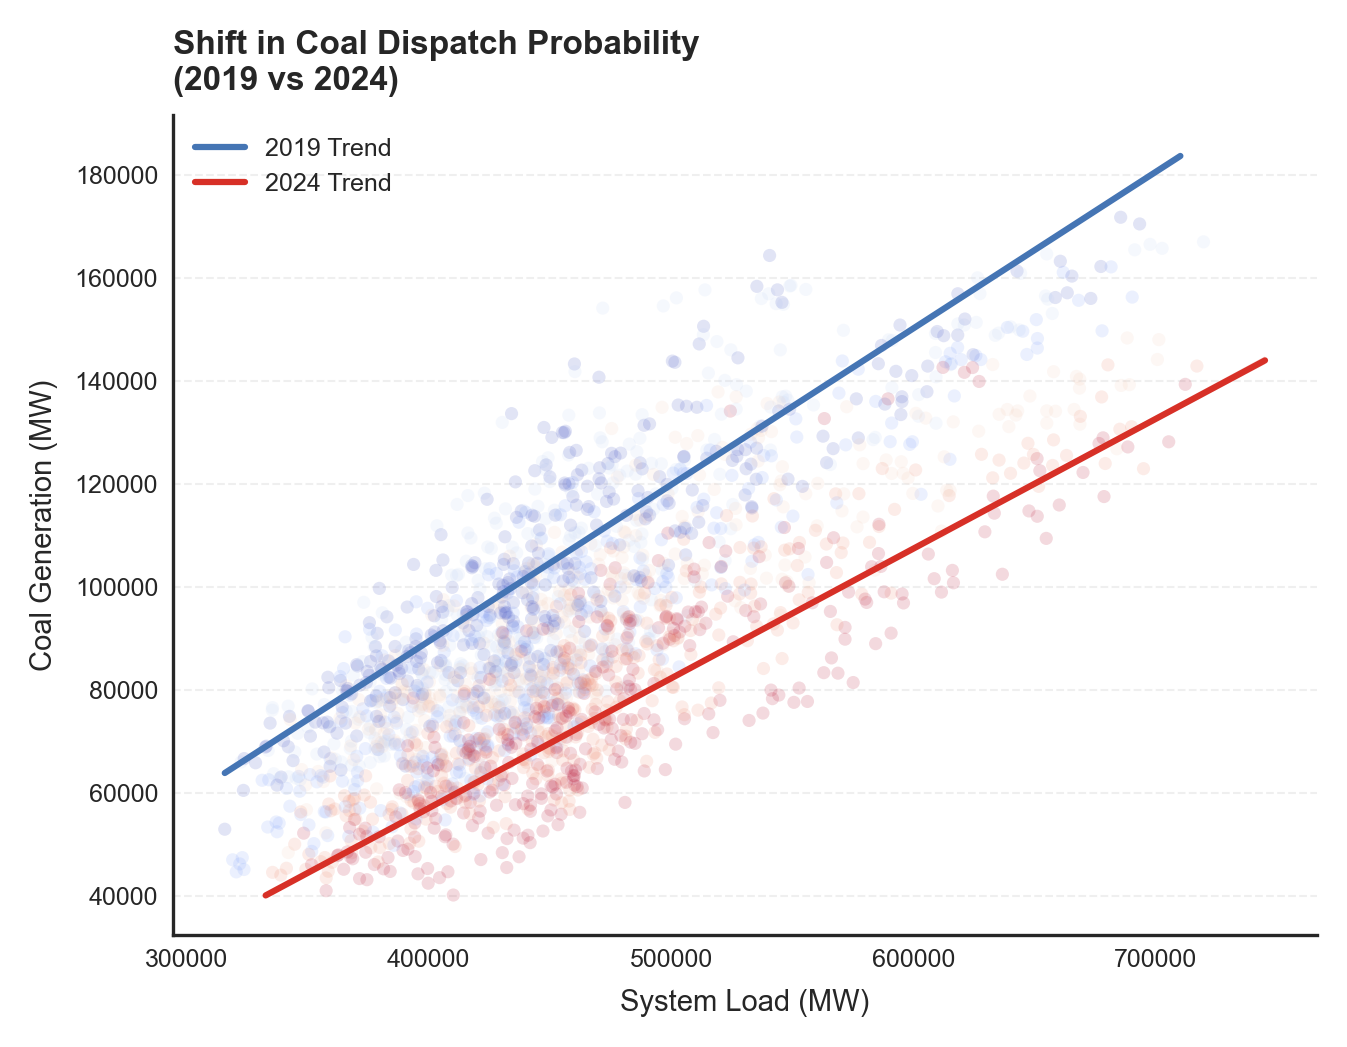

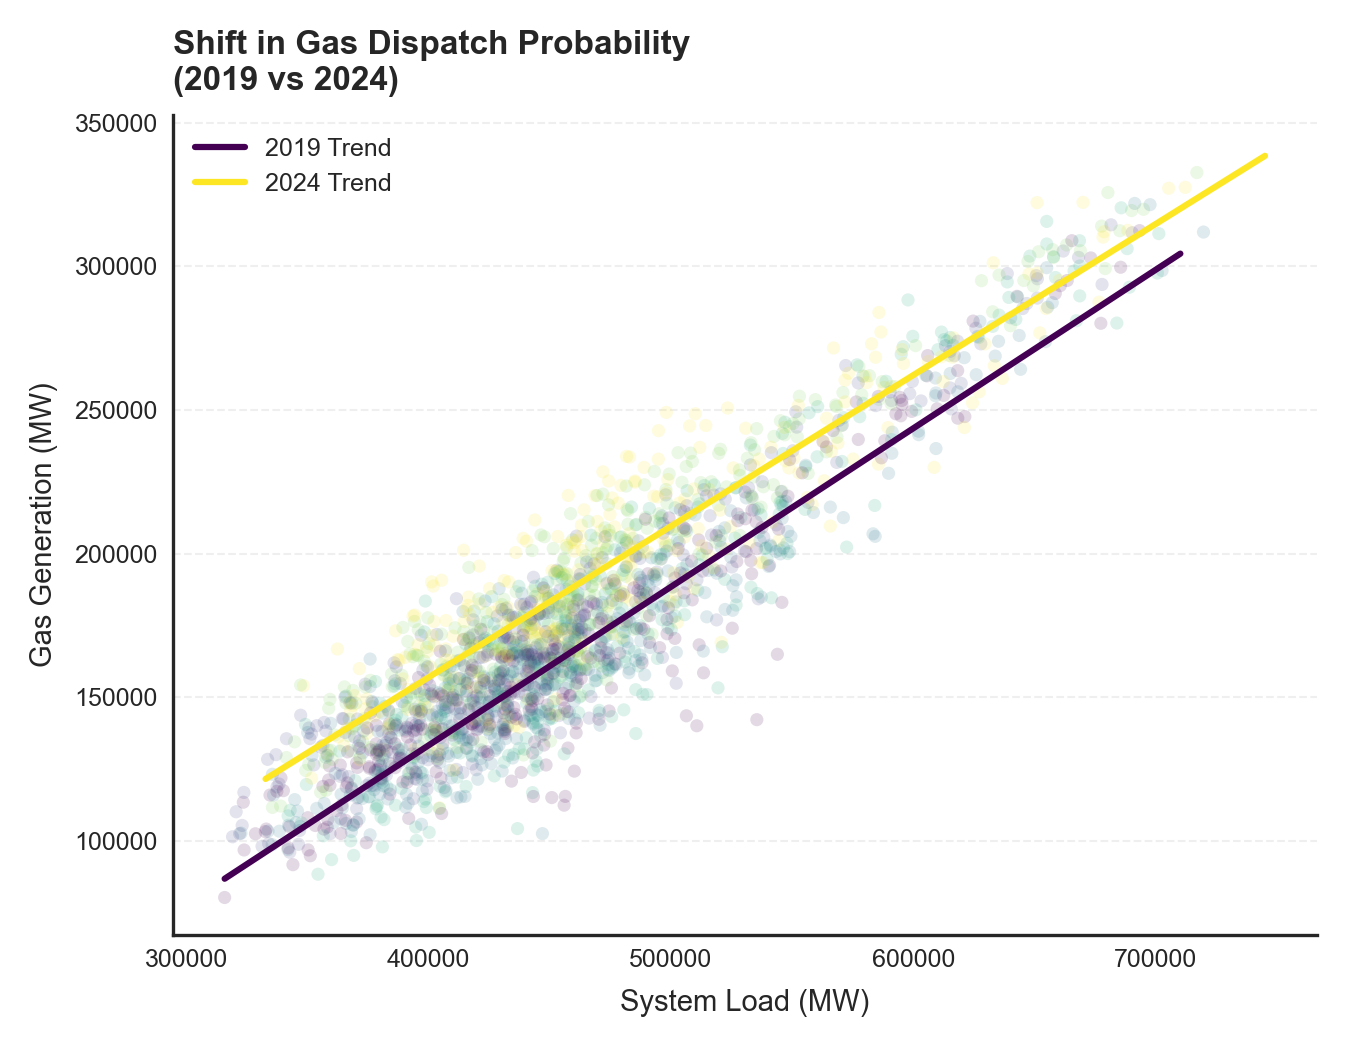

In [35]:
# %%
# ==========================================
# 6. VISUALIZATION: COAL SHIFT (Fixed Palette)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(4.5, 3.5)) 

start_year = df['year'].min()
end_year = df['year'].max()
n_years = df['year'].nunique()

# 1. Scatter Points 
sample = df.sample(n=min(2000, len(df)), random_state=42)

# FIX: Use a named palette that scales automatically to the number of years
sns.scatterplot(
    x='Load', y='Gen_Coal', data=sample, hue='year',
    palette='coolwarm',  # Automatically generates a Blue-to-Red gradient for all years
    alpha=0.15, s=10, legend=False, ax=ax, edgecolor='none'
)

# 2. Regression Lines (The "Signal")
# Start Year = Blue, End Year = Red
# We explicitly pick colors from the coolwarm spectrum to match the scatter background
line_colors = {start_year: '#4575b4', end_year: '#d73027'} # Coolwarm-like Blue/Red

for year, color in line_colors.items():
    subset = df[df['year'] == year]
    sns.regplot(
        x='Load', y='Gen_Coal', data=subset, scatter=False,
        label=f'{year} Trend', color=color, 
        ax=ax, line_kws={"lw": 1.5}
    )

# 3. Formal Formatting
ax.set_title(f'Shift in Coal Dispatch Probability\n({start_year} vs {end_year})', loc='left', weight='bold')
ax.set_xlabel('System Load (MW)')
ax.set_ylabel('Coal Generation (MW)')
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.3)
ax.legend(frameon=False, loc='upper left')

plt.tight_layout()
plt.show()

# %%
# ==========================================
# 7. VISUALIZATION: GAS SHIFT (Fixed Palette)
# ==========================================

fig, ax = plt.subplots(figsize=(4.5, 3.5)) 

# 1. Scatter Points 
# FIX: Use 'viridis' (Green/Purple/Blue) to match the Gas theme
sns.scatterplot(
    x='Load', y='Gen_Gas', data=sample, hue='year',
    palette='viridis', 
    alpha=0.15, s=10, legend=False, ax=ax, edgecolor='none'
)

# 2. Regression Lines
# Start Year = Blue/Purple (Viridis start), End Year = Yellow/Green (Viridis end)
gas_colors = {start_year: '#440154', end_year: '#fde725'} # Dark Purple vs Bright Yellow

for year, color in gas_colors.items():
    subset = df[df['year'] == year]
    linestyle = '-' 
    
    sns.regplot(
        x='Load', y='Gen_Gas', data=subset, scatter=False,
        label=f'{year} Trend', color=color, 
        ax=ax, line_kws={"lw": 1.5, "linestyle": linestyle}
    )

# 3. Formal Formatting
ax.set_title(f'Shift in Gas Dispatch Probability\n({start_year} vs {end_year})', loc='left', weight='bold')
ax.set_xlabel('System Load (MW)')
ax.set_ylabel('Gas Generation (MW)')
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.3)
ax.legend(frameon=False, loc='upper left')

plt.tight_layout()
plt.show()